# Project 2. Deep Learning
## Image Classification with CNN

#### Sandra Marcela Meneses - Angélica María Gómez Buitrago - Juan Camilo Castillo Castro - Diego Fernando López Castillo

* Conjunto: 600 imágenes con 6 categorías de pájaros. 
* Distribución: 100 imágenes de cada categoría:

# *Punto 3. Fine tuning*

* Repeat the experiment from the last question, but this time allow all the layers to be trained.
* Compare and discuss the results.

In [1]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
!pip install livelossplot # Instalar nuevos paquetes

gpg: keybox '/tmp/tmprbru_z0g/pubring.gpg' created
gpg: /tmp/tmprbru_z0g/trustdb.gpg: trustdb created
gpg: key AD5F235DF639B041: public key "Launchpad PPA for Alessandro Strada" imported
gpg: Total number processed: 1
gpg:               imported: 1


In [2]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
!pip install livelossplot # Instalar nuevos paquetes

gpg: keybox '/tmp/tmp2czkbain/pubring.gpg' created
gpg: /tmp/tmp2czkbain/trustdb.gpg: trustdb created
gpg: key AD5F235DF639B041: public key "Launchpad PPA for Alessandro Strada" imported
gpg: Total number processed: 1
gpg:               imported: 1


In [0]:
from google.colab import auth
auth.authenticate_user()

In [4]:
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

··········


In [5]:
!mkdir -p drive
!google-drive-ocamlfuse drive

fuse: mountpoint is not empty
fuse: if you are sure this is safe, use the 'nonempty' mount option


In [6]:
print('Files in Drive:')
!ls drive/birds_small/

Files in Drive:
test  train


In [0]:
# Code to read csv file into colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [10]:
# Download a file based on its file ID.

file_id = '1enos2Oo3cdDmO6X13UrNpI4q4Kd5hdsd'
downloaded = drive.CreateFile({'id': file_id})
print(downloaded['title'] )
#downloaded.GetContentFile(downloaded['title'])


birds_small


In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

Using TensorFlow backend.


In [0]:
from IPython.display import display 
from PIL import Image

In [10]:
import os
TRAIN_DIR = './drive/birds_small/train'
train_images = [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR)] # use this for training images
train_images

['./drive/birds_small/trainegret',
 './drive/birds_small/trainmandarin',
 './drive/birds_small/traintoucan',
 './drive/birds_small/trainpuffin',
 './drive/birds_small/trainwood_duck',
 './drive/birds_small/trainowl']

#### Visualización previa de imágenes

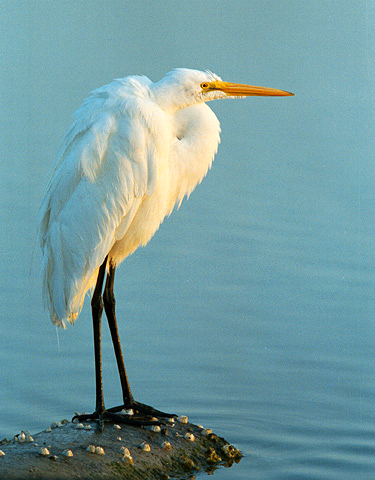

In [11]:
img = load_img('./drive/birds_small/train/egret/egr009.jpg')
img

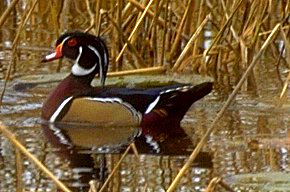

In [12]:
img = load_img('./drive/birds_small/train/wood_duck/wod009.jpg')
img

#### Librerias

In [0]:
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras import applications
from keras.utils.np_utils import to_categorical
from keras.applications import VGG16
from keras import optimizers

import matplotlib.pyplot as plt
import math
import numpy as np

## *Implementación:*

**Explicación 1: ** Se definen los siguientes parámetros:
* Dimensión de las imágenes de entrada
* Directorio de entrada train y test
* Batch_size

In [0]:
img_width, img_height = 224, 224
train_data_dir = 'drive/birds_small/train'
test_data_dir  = 'drive/birds_small/test'
epochs         = 50
batch_size     = 16

**Explicación 2:** Se extrae los pesos de la red neuronal pre-entrenada VGG16, especificando el parámetro include_top=false, para implementar el uso de todas las capas EXCEPTUANDO la última capa.

In [0]:
#Load the VGG model
model_vgg = VGG16(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

* Estructura de la red VGG16 sin la capa predictions (Dense) (None, 1000)  Param: 4097000

In [19]:
model_vgg.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

**Explicación 3:** Para congelar los pesos de una capa en particular, debemos establecer este parámetro en -False-. En este caso, seleccionamos todas las capas con -True- debido a que queremos entrenar todas las capas del modelo VGG16.

In [21]:
# Freeze the layers except the last 4 layers
for layer in model_vgg.layers[:-4]:
    layer.trainable = False
 
# Check the trainable status of the individual layers
for layer in model_vgg.layers:
    print(layer, layer.trainable)

<keras.engine.topology.InputLayer object at 0x7f1f9fbdae48> False
<keras.layers.convolutional.Conv2D object at 0x7f1f9fbdaef0> False
<keras.layers.convolutional.Conv2D object at 0x7f1f9fbdaeb8> False
<keras.layers.pooling.MaxPooling2D object at 0x7f1f9fbda160> False
<keras.layers.convolutional.Conv2D object at 0x7f1f9fbe4dd8> False
<keras.layers.convolutional.Conv2D object at 0x7f1f9fbfc860> False
<keras.layers.pooling.MaxPooling2D object at 0x7f1f9fc09630> False
<keras.layers.convolutional.Conv2D object at 0x7f1f9b8902e8> False
<keras.layers.convolutional.Conv2D object at 0x7f1f9b890160> False
<keras.layers.convolutional.Conv2D object at 0x7f1f9b8a5e48> False
<keras.layers.pooling.MaxPooling2D object at 0x7f1f9b847978> False
<keras.layers.convolutional.Conv2D object at 0x7f1f9b86d438> False
<keras.layers.convolutional.Conv2D object at 0x7f1f9b86d390> False
<keras.layers.convolutional.Conv2D object at 0x7f1f9b801e48> False
<keras.layers.pooling.MaxPooling2D object at 0x7f1f9b81b978> Fa

** Explicación 4: ** Se crea un nuevo modelo incluyendo la red base con todas sus capas listas para ser entrenadas. 

In [0]:
# Create the model
model = Sequential()
 
# Add the vgg convolutional base model
model.add(model_vgg)

# Add new layers
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(6, activation='sigmoid'))

** Estructura de la nueva red incluyendo las capas base de vgg16

In [23]:
# Show a summary of the model. Check the number of trainable parameters
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               6422784   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 1542      
Total params: 21,139,014
Trainable params: 13,503,750
Non-trainable params: 7,635,264
_________________________________________________________________


** Explicación 5: ** Se configura el generador de datos para el set train, se utiliza la funcionalidad -ImageDataGenerator- disponible en Keras para leer imágenes en lotes directamente desde la carpeta raíz y opcionalmente, realizar el aumento de datos.

In [0]:
datagen = ImageDataGenerator(rescale=1. / 255) #se reescala para que queden valores entre 0 y 1 

In [25]:
train_generator = datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)

Found 300 images belonging to 6 classes.


** Explicación 6: ** Se configura el generador de datos para el set test de forma similar al set train.

In [26]:
test_generator = datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)

Found 300 images belonging to 6 classes.


** Explicación 7: ** Se especifica un optimizador y la tasa de aprendizaje 

In [0]:
# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

In [0]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

In [0]:
model.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])  

**Explicación 8:** Se comienza a entrenar usando la función model.fit_generator (). 

In [28]:
# Train the model
history = model.fit_generator(
      train_generator,
      steps_per_epoch=train_generator.samples/train_generator.batch_size ,
      epochs=50,
      validation_data=test_generator,
      validation_steps=test_generator.samples/test_generator.batch_size,
      verbose=1)

Epoch 1/50
19/18 [==============================] - 13s 704ms/step - loss: 2.7211 - acc: 0.1415 - val_loss: 1.7758 - val_acc: 0.1667
Epoch 2/50
19/18 [==============================] - 9s 464ms/step - loss: 1.8282 - acc: 0.1689 - val_loss: 1.7182 - val_acc: 0.1667
Epoch 3/50
19/18 [==============================] - 9s 469ms/step - loss: 1.7415 - acc: 0.3006 - val_loss: 1.6495 - val_acc: 0.2567
Epoch 4/50
19/18 [==============================] - 9s 466ms/step - loss: 1.5629 - acc: 0.4125 - val_loss: 1.2128 - val_acc: 0.5967
Epoch 5/50
19/18 [==============================] - 9s 489ms/step - loss: 1.2235 - acc: 0.6493 - val_loss: 1.0554 - val_acc: 0.5600
Epoch 6/50
19/18 [==============================] - 9s 466ms/step - loss: 0.8992 - acc: 0.6873 - val_loss: 1.0409 - val_acc: 0.5600
Epoch 7/50
19/18 [==============================] - 9s 468ms/step - loss: 0.6117 - acc: 0.7677 - val_loss: 0.5991 - val_acc: 0.7900
Epoch 8/50
19/18 [==============================] - 9s 468ms/step - loss: 0

19/18 [==============================] - 9s 467ms/step - loss: 0.3468 - acc: 0.8882 - val_loss: 0.3202 - val_acc: 0.8600
Epoch 10/50
19/18 [==============================] - 9s 466ms/step - loss: 0.2398 - acc: 0.9233 - val_loss: 0.4669 - val_acc: 0.8533
Epoch 11/50
19/18 [==============================] - 9s 465ms/step - loss: 0.3468 - acc: 0.8903 - val_loss: 0.4728 - val_acc: 0.8900
Epoch 12/50
19/18 [==============================] - 9s 467ms/step - loss: 0.1130 - acc: 0.9835 - val_loss: 0.1952 - val_acc: 0.9300
Epoch 13/50
19/18 [==============================] - 9s 464ms/step - loss: 0.0776 - acc: 0.9683 - val_loss: 0.6879 - val_acc: 0.7667
Epoch 14/50
19/18 [==============================] - 9s 470ms/step - loss: 0.0842 - acc: 0.9704 - val_loss: 0.3003 - val_acc: 0.9100
Epoch 15/50
19/18 [==============================] - 9s 461ms/step - loss: 0.0095 - acc: 1.0000 - val_loss: 0.2178 - val_acc: 0.9367
Epoch 16/50
19/18 [==============================] - 9s 465ms/step - loss: 0.0013

19/18 [==============================] - 9s 461ms/step - loss: 0.2047 - acc: 0.9473 - val_loss: 0.3018 - val_acc: 0.9067
Epoch 18/50
19/18 [==============================] - 9s 489ms/step - loss: 0.0213 - acc: 0.9967 - val_loss: 0.2791 - val_acc: 0.9033
Epoch 19/50
19/18 [==============================] - 9s 469ms/step - loss: 0.0041 - acc: 1.0000 - val_loss: 0.2045 - val_acc: 0.9267
Epoch 20/50
19/18 [==============================] - 9s 466ms/step - loss: 0.2903 - acc: 0.9572 - val_loss: 0.2157 - val_acc: 0.9033
Epoch 21/50
19/18 [==============================] - 9s 468ms/step - loss: 0.0125 - acc: 0.9967 - val_loss: 0.1628 - val_acc: 0.9267
Epoch 22/50
19/18 [==============================] - 9s 468ms/step - loss: 0.0024 - acc: 1.0000 - val_loss: 0.2491 - val_acc: 0.9100
Epoch 23/50
19/18 [==============================] - 9s 463ms/step - loss: 0.0021 - acc: 1.0000 - val_loss: 0.2448 - val_acc: 0.9200
Epoch 24/50
19/18 [==============================] - 9s 466ms/step - loss: 0.0844

19/18 [==============================] - 9s 480ms/step - loss: 0.0028 - acc: 1.0000 - val_loss: 0.4279 - val_acc: 0.9067
Epoch 26/50
19/18 [==============================] - 9s 458ms/step - loss: 0.0127 - acc: 0.9901 - val_loss: 0.1763 - val_acc: 0.9567
Epoch 27/50
19/18 [==============================] - 9s 462ms/step - loss: 0.0503 - acc: 0.9934 - val_loss: 1.3767 - val_acc: 0.8100
Epoch 28/50
19/18 [==============================] - 9s 461ms/step - loss: 0.1740 - acc: 0.9638 - val_loss: 0.1661 - val_acc: 0.9533
Epoch 29/50
19/18 [==============================] - 9s 464ms/step - loss: 0.0016 - acc: 1.0000 - val_loss: 0.1820 - val_acc: 0.9567
Epoch 30/50
19/18 [==============================] - 9s 463ms/step - loss: 4.5421e-04 - acc: 1.0000 - val_loss: 0.1868 - val_acc: 0.9500
Epoch 31/50
19/18 [==============================] - 9s 460ms/step - loss: 0.0249 - acc: 0.9934 - val_loss: 0.8196 - val_acc: 0.8467
Epoch 32/50
19/18 [==============================] - 9s 491ms/step - loss: 0.

19/18 [==============================] - 9s 460ms/step - loss: 4.1070e-04 - acc: 1.0000 - val_loss: 0.1925 - val_acc: 0.9533
Epoch 34/50
19/18 [==============================] - 9s 462ms/step - loss: 2.5476e-04 - acc: 1.0000 - val_loss: 0.3735 - val_acc: 0.9400
Epoch 35/50
19/18 [==============================] - 9s 468ms/step - loss: 6.0058e-05 - acc: 1.0000 - val_loss: 0.3731 - val_acc: 0.9200
Epoch 36/50
19/18 [==============================] - 9s 463ms/step - loss: 0.0156 - acc: 0.9967 - val_loss: 0.2825 - val_acc: 0.9433
Epoch 37/50
19/18 [==============================] - 9s 467ms/step - loss: 6.1764e-04 - acc: 1.0000 - val_loss: 0.2474 - val_acc: 0.9433
Epoch 38/50
19/18 [==============================] - 9s 460ms/step - loss: 5.9422e-05 - acc: 1.0000 - val_loss: 0.2130 - val_acc: 0.9600
Epoch 39/50
19/18 [==============================] - 9s 481ms/step - loss: 7.9534e-05 - acc: 1.0000 - val_loss: 0.3894 - val_acc: 0.9367
Epoch 40/50
19/18 [==============================] - 9s 4

19/18 [==============================] - 9s 462ms/step - loss: 7.6972e-06 - acc: 1.0000 - val_loss: 0.4120 - val_acc: 0.9333
Epoch 42/50
19/18 [==============================] - 9s 464ms/step - loss: 0.3361 - acc: 0.9390 - val_loss: 0.4505 - val_acc: 0.8500
Epoch 43/50
19/18 [==============================] - 9s 466ms/step - loss: 0.0291 - acc: 0.9901 - val_loss: 0.1514 - val_acc: 0.9533
Epoch 44/50
19/18 [==============================] - 9s 461ms/step - loss: 0.0013 - acc: 1.0000 - val_loss: 0.1563 - val_acc: 0.9633
Epoch 45/50
19/18 [==============================] - 9s 463ms/step - loss: 4.4744e-04 - acc: 1.0000 - val_loss: 0.1311 - val_acc: 0.9667
Epoch 46/50
19/18 [==============================] - 9s 463ms/step - loss: 3.2471e-04 - acc: 1.0000 - val_loss: 0.3255 - val_acc: 0.9300
Epoch 47/50
19/18 [==============================] - 9s 465ms/step - loss: 0.0606 - acc: 0.9868 - val_loss: 0.2111 - val_acc: 0.9533
Epoch 48/50
19/18 [==============================] - 9s 467ms/step - 

19/18 [==============================] - 9s 467ms/step - loss: 6.1547e-05 - acc: 1.0000 - val_loss: 0.1716 - val_acc: 0.9600
Epoch 50/50
19/18 [==============================] - 9s 468ms/step - loss: 1.0372e-05 - acc: 1.0000 - val_loss: 0.1691 - val_acc: 0.9567


In [0]:
(eval_loss, eval_accuracy) = model.evaluate_generator(test_generator)

In [244]:
eval_loss 

0.25747851906596525

In [30]:
eval_accuracy

0.9566666666666667

**Explicación 9:** Representación gráfica del desempeño de la red en el set train y en el set test bajo la función de perdida y el Accuracy.

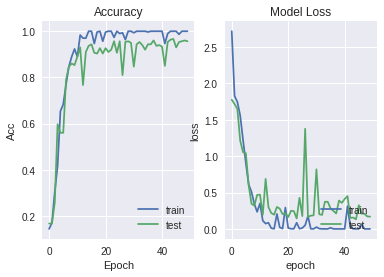

In [31]:
plt.figure(1)
plt.subplot(121)  
plt.plot(history.history['acc'])  
plt.plot(history.history['val_acc'])  
plt.title('Accuracy')  
plt.ylabel('Acc')  
plt.xlabel('Epoch')  
plt.legend(['train', 'test'], loc='lower right')


plt.subplot(122)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('Model Loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='lower right')  
plt.show() 

**Explicación 10:** Se crean las etiquetas de las clases para  las muestras de train y test, para lo cual también se emplea la función 'DataGenerator'. Luego, las etiquetas se convierten en variables categóricas.

In [32]:
test_generator = datagen.flow_from_directory(
        test_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)
 
# Get the filenames from the generator
fnames = test_generator.filenames
 
# Get the ground truth from generator
ground_truth = test_generator.classes
 
# Get the label to class mapping from the generator
label2index = test_generator.class_indices
 
# Getting the mapping from class index to class label
idx2label = dict((v,k) for k,v in label2index.items())
idx2label

Found 300 images belonging to 6 classes.


{0: 'egret', 1: 'mandarin', 2: 'owl', 3: 'puffin', 4: 'toucan', 5: 'wood_duck'}

**Explicación 11:** Categorías de las clases para  las muestra test.

In [33]:
ground_truth

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5], d

**Explicación 12:** Predicción en términos de la (Probabilidad)

In [34]:
predictions = model.predict_generator(test_generator, steps=test_generator.samples/test_generator.batch_size,verbose=1)

19/18 [==============================] - 4s 188ms/step


In [35]:
predictions

array([[7.8308332e-01, 7.8376950e-15, 3.7141270e-18, 1.4503555e-12,
        5.2301141e-17, 1.7558366e-13],
       [1.7402817e-01, 1.8129318e-05, 1.7265866e-06, 8.3314018e-07,
        7.2686748e-06, 6.3562183e-08],
       [5.1259053e-01, 7.2410594e-10, 3.4695680e-11, 2.8027075e-12,
        1.9664559e-12, 2.3642874e-09],
       ...,
       [1.0968852e-10, 5.4466502e-09, 3.9389686e-10, 4.4810125e-08,
        9.7301993e-11, 9.9849963e-01],
       [5.0547935e-14, 1.8324929e-10, 6.0505230e-14, 5.4253871e-12,
        5.8580191e-10, 5.6875908e-01],
       [4.5290332e-17, 3.2508005e-12, 5.3827758e-16, 8.2083124e-17,
        8.9135692e-18, 9.9987018e-01]], dtype=float32)

**Explicación 13:**  Se convirtierte las probabilidades en clases.

In [36]:
predicted_classes = np.argmax(predictions,axis=1)
predicted_classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 5, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 5, 1, 3, 3, 3, 3, 3, 3,
       3, 3, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 1, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 1, 4, 4, 4, 4, 5, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5])

**Explicación 14:** Construcción de la matriz de confusión:

In [37]:
from sklearn.metrics import confusion_matrix 
cm = confusion_matrix(ground_truth, predicted_classes)
cm

array([[49,  0,  0,  0,  1,  0],
       [ 0, 47,  0,  0,  2,  1],
       [ 0,  1, 49,  0,  0,  0],
       [ 0,  2,  0, 47,  0,  1],
       [ 0,  3,  0,  0, 45,  2],
       [ 0,  0,  0,  0,  0, 50]])

* Definición de función para graficar la matriz de confusión:

In [0]:
def plot_confusion_matrix(cm, names, title='MATRIZ DE CONFUSIÓN', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('Clase real')
    plt.xlabel('Clase predicha')

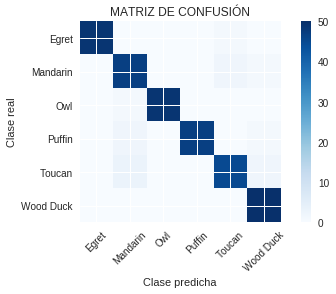

In [39]:
plt.figure()
plot_confusion_matrix(cm, ['Egret','Mandarin','Owl','Puffin','Toucan','Wood Duck'])

In [256]:
model.save('punto3pesos.h5')
!ls

data  datalab  drive  punto3pesos.h5


**Explicación 15:** Errores cometidos en la predicción sobre el conjunto test.

In [44]:
errors = np.where(predicted_classes != ground_truth)[0]
print("No of errors = {}/{}".format(len(errors),test_generator.samples))
 
# Show the errors
for i in range(len(errors)):
    pred_class = np.argmax(predictions[errors[i]])
    pred_label = idx2label[pred_class]
     
    title = 'Original label:{}, Prediction :{}, confidence : {:.3f}'.format(
        fnames[errors[i]].split('/')[0],
        pred_label,
        predictions[errors[i]][pred_class])
     
    original = load_img('{}/{}'.format(test_data_dir,fnames[errors[i]]))
    plt.figure(figsize=[7,7])
    plt.axis('off')
    plt.title(title)
    plt.imshow(original)
    plt.show()

**Resultado final: ** Como conclusión final podemos ver que la red neuronal solo se equivoco en 13 aves de 600, con lo cual se demuestra que una red que emplea Transfer Learning y Fine tunning brinda excelentes resultados.   




Resultados obtenidos mediante compilación :

* model.compile(loss='categorical_crossentropy',optimizer=optimizers.RMSprop(lr=1e-4), metrics=['acc'])

* Entrenamiento últimas 4 capas

* Se probó  entrenar con todas las capas pero no estaba generando buenos resultados al momento de evaluarlo mediante la función de perdida y el Accuracy por eso, se optó por dejar la configuración de entrenamiento con las últimas 4 capas del modelo pre-entrenado.